<a href="https://colab.research.google.com/github/auwal84/traffic-classification/blob/master/semi_GAN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0
#!pip install tensorflow==2.0.0-alpha0

In [0]:
import tensorflow as tf 
import numpy as np 
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
import pandas as pd
print("TensorFlow version: {}".format(tf.__version__))

print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.0.0-alpha0
Eager execution: True


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
def load_data():
    train_data = np.load('Traindataset_GAN3.npy')
    train_labels = np.load('TrainLabels_GAN3.npy')
    test_data = np.load('Testdataset_GAN3.npy')
    test_labels = np.load('test_labels_GAN3.npy')
    return (train_data,train_labels),(test_data,test_labels)

In [0]:
(train_data,train_labels),(test_data,test_labels) = load_data()


In [0]:
train_data = tf.cast(train_data,tf.float32)
train_data = tf.reshape(train_data,[-1,20,3,1])

In [0]:
train_data = tf.cast(train_data,tf.float32)
train_data = tf.reshape(train_data,[-1,20,3,1])

train_labels = tf.cast(train_labels,tf.int32)
train_labels = tf.one_hot(train_labels,4)

In [0]:
test_labels = tf.cast(test_labels,tf.int32)
test_labels = tf.one_hot(test_labels,4)
test_data = tf.cast(test_data,tf.float32)
test_data = tf.reshape(test_data,[-1,20,3,1])

In [0]:
num_classes = 4
BUFFER_SIZE = 60000
BATCH_SIZE = 250

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data,train_labels))
train_dataset = train_dataset.batch(BATCH_SIZE,drop_remainder = True)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data,test_labels)).batch(BATCH_SIZE,  drop_remainder = True)                                                  

In [0]:
def get_labeled_mask(labeled_rate):
    # get labeled mask to mask some data unlabeled
    labeled_mask = np.zeros([BATCH_SIZE], dtype = np.float32)
    labeled_count = np.int(BATCH_SIZE * labeled_rate)
    labeled_mask[range(labeled_count)] = 1.0
    #np.random.shuffle(labeled_mask)

    return labeled_mask

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(60*1*16, use_bias=False, input_shape=(1920,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha = 1))
      
    model.add(tf.keras.layers.Reshape((20, 3, 16)))
    assert model.output_shape == (None, 20, 3, 16) # Note: None is the batch size
    
    model.add(tf.keras.layers.Conv2DTranspose(8, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None,20, 3, 8)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(4, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None,20, 3, 4)    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None,20, 3, 1)
  
    return model

In [0]:

def make_discriminator_model():
    dropout_rate = 0.5
    num_classes = 4
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dropout(dropout_rate))
    #layer 1
    model.add(tf.keras.layers.Conv2D(32,(5,5),strides = (1,1), padding = 'same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    #layer2
    model.add(tf.keras.layers.Conv2D(64,(3,3),strides = (1,1),padding = 'same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha = 0.2))
    
    model.add(tf.keras.layers.Conv2D(64,(2,2), strides = (1,1), padding = 'same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha = 0.2))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Conv2D(128,(2,2),strides =(1,1),padding = 'same'))
    model.add(tf.keras.layers.LeakyReLU(alpha = 0.2))
    model.add(tf.keras.layers.GlobalMaxPooling2D())
    #model.add(tf.keras.layers.Dense(num_classes+1))
    #model.add(tf.keras.layers.Softmax())
    return model

    

In [0]:
Dense = tf.keras.layers.Dense(5)

In [0]:
discriminator  = make_discriminator_model()
generator = make_generator_model()


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [0]:

# metrics
# metrics
loss_g = tf.keras.metrics.Mean(name='gen_train_loss')
loss_d = tf.keras.metrics.Mean(name='disc_train_loss')
#train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()


In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [0]:
#discriminator loss
def discriminator_loss(D_real_logits,generated_output,extended_labels,D_real_prob):
    #supervised loss
    #extended_labels = tf.one_hot(extended_labels,4)
    tmp = tf.nn.softmax_cross_entropy_with_logits(logits = D_real_logits,
                                                  labels = extended_labels)
    labeled_mask = np.zeros([BATCH_SIZE], dtype = np.float32)
    labeled_count = np.int(BATCH_SIZE * 0.1)
    labeled_mask[range(labeled_count)] = 1.0
    D_L_supervised = tf.reduce_sum(labeled_mask * tmp) / tf.reduce_sum(labeled_mask)
    #unsupervised loss
    epsilon = 1e-8
    
    prob_real_be_real = 1 - D_real_prob[:, -1] + epsilon
    tmp_log = tf.math.log(prob_real_be_real)
    D_L_unsupervised1 = -1 * tf.reduce_mean(tmp_log)
     # data is fake
    D_fake_prob = tf.nn.softmax(generated_output)
    prob_fake_be_fake = D_fake_prob[:, -1] + epsilon
    tmp_log = tf.math.log(prob_fake_be_fake)
    D_L_unsupervised2 = -1 * tf.reduce_mean(tmp_log)

    disc_loss = D_L_supervised + D_L_unsupervised1 + D_L_unsupervised2
    return disc_loss


In [0]:
def generator_loss(data_features, generated_features, D_fake_prob ):
    # fake data is mistaken to be real
    epsilon = 1e-8
    
    prob_fake_be_real = 1 - D_fake_prob[:, -1] + epsilon
    tmp_log =  tf.math.log(prob_fake_be_real)
    G_L1 = -1 * tf.reduce_mean(tmp_log)

    real_moments = tf.reduce_mean(data_features, axis = 0)
    generated_moments = tf.reduce_mean(generated_features, axis = 0)
    G_L2 = tf.reduce_mean(tf.abs(real_moments - generated_moments))
    #tmp1 = tf.reduce_mean(data_features, axis = 0)
    #tmp2 = tf.reduce_mean(generated_features, axis = 0)
    #G_L2 = tf.reduce_mean(tf.square(tmp1 - tmp2))
    #gen_loss = G_L1 + G_L2
    gen_loss = G_L2
    return gen_loss

In [0]:
def prepare_labels(label):
    # add extra label for fake data

    extended_label = tf.concat([label, tf.zeros([tf.shape(label)[0], 1])], axis = 1)

    return extended_label

In [0]:
class metric():
    def __init__(self):
        self.label = 0
        self.logit = 0
         
    def setValues(self,a,b):
        self.label = a
        self.logits = b
        
    def report(self):
        Y_true = tf.argmax(self.label,1).numpy()
        #Y_true= tf.cast(self.label,tf.int32).numpy()
        
        Y_predict = tf.argmax(self.logits,axis = 1,output_type=tf.int32).numpy()

        report = f1_score(Y_true, Y_predict,average = 'micro')
        return report
    

In [0]:
metric_train = metric()
metric_test = metric()

In [0]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), generator_optimizer=generator_optimizer, discriminator_optimizer =
                           discriminator_optimizer,generator = generator,discriminator = discriminator)
manager = tf.train.CheckpointManager(ckpt, 'content/gdrive/My Drive/semiGAN_tf_ckpts4', max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [0]:


def train_step(features, labels):
    noise_dim = 1920
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)
        real_features = discriminator(features, training = True)
        D_real_logits = Dense(real_features)
        D_real_prob = tf.nn.softmax(D_real_logits)
        generated_features = discriminator(generated_images, training = True)
        generated_output = Dense(generated_features)
        D_fake_prob = tf.nn.softmax(generated_output)
        gen_loss = generator_loss(real_features,generated_features,D_fake_prob)
        extended_labels = prepare_labels(labels)
        disc_loss = discriminator_loss(D_real_logits,generated_output,extended_labels,D_real_prob)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables)) 
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    loss_g(gen_loss)
    loss_d(disc_loss)
    train_accuracy(extended_labels,D_real_prob )
    precision(extended_labels,D_real_prob)
    recall(extended_labels,D_real_prob)
    #metric_train.setValues(extended_labels,D_real_prob )
 

In [0]:
def test_step(features, labels):
    noise_dim = 1920
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    #noise = tf.random.uniform(BATCH_SIZE, noise_dim)
    real_features = discriminator(features, training = True)
    D_real_logits = Dense(real_features)
    D_real_prob = tf.nn.softmax(D_real_logits)
    generated_images = generator(noise)
    generated_features = discriminator(features, training = True)
    generated_output = Dense(generated_features )
    t_D_fake_prob = tf.nn.softmax(generated_output)
    gen_loss = generator_loss(real_features,generated_features,t_D_fake_prob)
    test_labels = prepare_labels(labels)
    disc_loss = discriminator_loss(D_real_logits,generated_output,test_labels,D_real_prob)
    loss_g(gen_loss)
    loss_d(disc_loss)
    test_accuracy(test_labels,t_D_fake_prob)
    precision(test_labels,D_real_prob)
    recall(test_labels,D_real_prob)
    metric_test.setValues(test_labels , D_real_prob)

In [0]:



log_path = 'content/gdrive/My Drive/SSL_GAN_0.1_log.csv'

In [0]:
def log_loss_acc(file_path, test_accuracy, precision, recall, f1_score, log_mode = 'w'):
    
    mode = log_mode 

    with open(file_path, mode) as f:
        if mode == 'w':
            header = 'accuraacy, precision,recall, f1 score\n'
            f.write(header)

        line =  '%f, %f, %f, %f\n' %(test_accuracy, precision, recall, f1_score)
        f.write(line)

In [0]:
train_accuracy_results = []
test_accuracy_results =[]
test_precision = []
test_recall =[]
f1_score_result =[]
print('now training')
EPOCHS = 500
for epoch in range(EPOCHS):
   
    for features,labels in train_dataset:
    
        
        train_step(features,labels)
        #report = metric_train.report()
    print('epoch: %d, | train_G_Loss: %f, ' \
                      'train_D_loss: %f, train_acc: %f' %(epoch,loss_g.result(), loss_d.result(),
                                                          train_accuracy.result().numpy()))
                                                               
    for features,labels in test_dataset:
        test_step(features, labels)
        ckpt.step.assign_add(1)
    
    f = metric_test.report()    
    print('epoch: %d, | train_G_Loss: %f, ' \
                      'train_D_loss: %f,test accuracy: %f,f1 score:%f' %(epoch,loss_g.result(), loss_d.result(),
                                                          test_accuracy.result().numpy(),f))
                                              
    if epoch % 5 == 0:
      save_path = manager.save()
      print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
        
    
    train_accuracy_results.append(train_accuracy.result().numpy())
    test_accuracy_results.append(test_accuracy.result().numpy())
    f1_score_result.append(f)
  
    log_loss_acc(log_path,test_accuracy.result().numpy(),precision.result().numpy(),recall.result().numpy(),f)
    
    
    

now training
epoch: 0, | train_G_Loss: 0.137410, train_D_loss: 2.516293, train_acc: 0.529217
epoch: 0, | train_G_Loss: 0.119554, train_D_loss: 2.946398,test accuracy: 0.304167,f1 score:0.936000
Saved checkpoint for step 49: content/gdrive/My Drive/semiGAN_tf_ckpts4/ckpt-1
epoch: 1, | train_G_Loss: 0.108459, train_D_loss: 2.759475, train_acc: 0.536483
epoch: 1, | train_G_Loss: 0.101794, train_D_loss: 2.932027,test accuracy: 0.302542,f1 score:0.912000
epoch: 2, | train_G_Loss: 0.102353, train_D_loss: 2.759365, train_acc: 0.547589
epoch: 2, | train_G_Loss: 0.098230, train_D_loss: 2.851352,test accuracy: 0.303167,f1 score:0.920000
epoch: 3, | train_G_Loss: 0.107414, train_D_loss: 2.660609, train_acc: 0.563913
epoch: 3, | train_G_Loss: 0.104152, train_D_loss: 2.735160,test accuracy: 0.308688,f1 score:0.944000
epoch: 4, | train_G_Loss: 0.117011, train_D_loss: 2.557676, train_acc: 0.581010
epoch: 4, | train_G_Loss: 0.114105, train_D_loss: 2.623705,test accuracy: 0.315150,f1 score:0.980000
epo

# New Section

In [0]:
googleDoc  = report2['GoogleDoc'].values()
googleDrive = report2['GoogleDrive'].values()
googleMusic = report2['GoogleMusic'].values()
youtube     = report2['Youtube'].values()          
report2

NameError: ignored

In [0]:
fi_1_score = [googleDoc[0],googleDrive[0],googleMusic[0],youtube[0]] 
precision = [googleDoc[1],googleDrive[1],googleMusic[1],youtube[1]] 
recall = [googleDoc[3],googleDrive[3],googleMusic[3],youtube[3]]

NameError: ignored

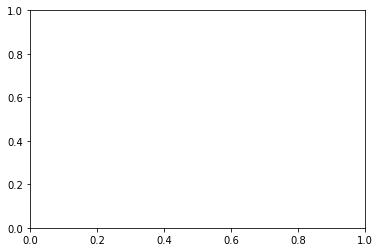

In [0]:
n_groups = 4

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8
rects1 = plt.bar(index, fi_1_score,bar_width, alpha=opacity,color='b',label='f1 score')
rects2 = plt.bar(index + bar_width , precision, bar_width,alpha=opacity,color='g',label='precision')
rects3 = plt.bar(index + bar_width + bar_width, recall, bar_width,alpha=opacity,color='r',label='recall')

plt.xlabel('classes')
plt.ylabel('scores')
plt.title('per class performance metrics')
plt.xticks(index + bar_width, ('GoogleDoc', 'GoogleDrive', 'GoogleMusic', 'Youtube'))
plt.legend()

plt.tight_layout()
plt.show()
#plt.savefig('/content/gdrive/My Drive/figure0.1')

In [0]:
from matplotlib import pyplot as plt 
#plt.plot(train_accuracy_results)
plt.plot(test_accuracy_results)
plt.title('model acurracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
#plt.legend(['train', 'test'], loc='upper left')
plt.legend(['test'], loc='upper left')
plt.show()
#plt.savefig('/content/gdrive/My Drive/figure0.1')
    


In [0]:
list1 =['accuracy','f1 score']
list2 = [test_accuracy_results,f1_score_result]
metric = dict(zip(list1,list2))

In [0]:
df = pd.DataFrame(metric)

In [0]:
df.to_csv('content/gdrive/My Drive/metric_0.1.csv')

In [0]:
df1 = pd.read_csv('metric_0.1.csv')


In [0]:
test1 = df1['accuracy']

In [0]:
df2 = pd.read_csv('metric_0.5.csv')
test2 = df2['accuracy']

In [0]:
df3 = pd.read_csv('cnn_metric.csv')


In [0]:
test3 = df3['accuracy']

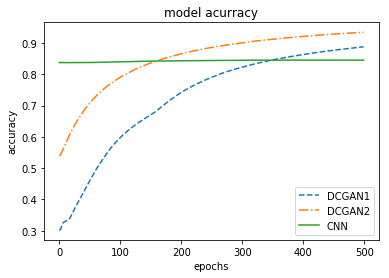

In [0]:
from matplotlib import pyplot as plt 
plt.plot(test1,linestyle = '--')
plt.plot(test2,linestyle = '-.')
plt.plot(test3)
plt.title('model acurracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['DCGAN1', 'DCGAN2','CNN'], loc='lower right')
#plt.legend(['test'], loc='lower left')
plt.show()
#plt.savefig('/content/gdrive/My Drive/figure0.1')
    